In [90]:
import sys
sys.path.insert(0, 'C:/Users/chris/Documents/GitHub/AzureFunctions/AzureFunctions')
import datetime
import logging
import time
from datetime import date
import os
from io import BytesIO
import pandas as pd
import yfinance as yf


from azure.storage.filedatalake import DataLakeServiceClient
import azure.functions as func
from shared_code import utils

pd.set_option('display.max_columns', None)

In [2]:
azure_utils = utils.AzureUtils()
secret_client = azure_utils.initialize_key_vault()

sa_secret = azure_utils.get_key_vault_secret(secret_client, 'sa-secret')
sa_name = azure_utils.get_key_vault_secret(secret_client, 'sa-name')

azure_utils.initialize_storage_account_ad(sa_secret.value, sa_name.value)
azure_utils.initialize_data_lake(sa_name.value, sa_secret.value)

In [5]:
selected_cols = [
    'Ticker',
    'ObservationDate',
    'mostRecentQuarter',
    'fullTimeEmployees',
    'ebitdaMargins',
    'profitMargins',
    'grossMargins',
    'operatingCashflow',
    'revenueGrowth',
    'operatingMargins',
    'ebitda',
    'targetLowPrice',
    'recommendationKey',
    'grossProfits',
    'freeCashflow',
    'targetMedianPrice',
    'currentPrice',
    'earningsGrowth',
    'currentRatio',
    'returnOnAssets',
    'numberOfAnalystOpinions',
    'targetMeanPrice',
    'debtToEquity',
    'returnOnEquity',
    'targetHighPrice',
    'totalCash',
    'totalDebt',
    'totalRevenue',
    'recommendationMean',
    'enterpriseToRevenue',
    'enterpriseToEbitda',
    '52WeekChange',
    'morningStarRiskRating',
    'forwardEps',
    'sharesOutstanding',
    'heldPercentInstitutions',
    'trailingEps',
    'lastDividendValue',
    'priceToBook',
    'heldPercentInsiders',
    'beta',
    'enterpriseValue',
    'priceToSalesTrailing12Months',
    'forwardPE',
    'trailingPE',
    'marketCap'
]
cols_to_exclude = ['Ticker', 'ObservationDate', 'recommendationKey', 'mostRecentQuarter']

dataCleaning_utils = utils.DataCleaning()

df_cleaning = (
    azure_utils.ingest_bronze_data(f"fundamentals/{date.today()}")
    .pipe(dataCleaning_utils.pivot_fundamentals_dataframe)
    .pipe(dataCleaning_utils.select_dataframe_columns, selected_cols)
    .pipe(dataCleaning_utils.set_dtype_to_numeric, cols_to_exclude)
    .pipe(dataCleaning_utils.change_timestamp_to_datetime, "mostRecentQuarter")
    .pipe(dataCleaning_utils.change_timestamp_format, "ObservationDate")
)

df_cleaning.head()

Attribute,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2023-01-09,2022-09-30,101120.0,0.09972,0.01197,0.16392,-338000000.0,0.312,0.03579,...,10.03,0.5,5.6218,0.89722,1.756146,101080178688.0,2.22563,NaN,16.64008,83449995264.0
1,AAK.ST,2023-01-09,2022-09-30,4000.0,0.0645,0.0364,0.19491,-896000000.0,0.444,0.05594,...,6.7,2.5,3.132811,0.30535,0.483529,53529649152.0,0.998955,21.279068,27.313433,47499296768.0
2,ABB.ST,2023-01-09,2022-09-30,106380.0,0.15502,0.13646,0.32536,1620000000.0,0.054,0.12882,...,21.55,0.82,54.471928,0.00037,1.022745,639808831488.0,21.963806,20.134819,15.939675,641101529088.0
3,ABLI.ST,2023-01-09,2022-09-30,8.0,0.0,0.0,0.0,-193664000.0,-0.647,-1260.595,...,-0.313,NaN,0.665505,0.07793,0.83392,45354652.0,2648.5413,NaN,NaN,209234768.0
4,ACAD.ST,2023-01-09,2022-09-30,13982.0,0.10508,0.04122,0.30712,2779000064.0,0.066,0.08684,...,5.57,1.75,0.814665,0.24961,0.964313,15362728960.0,0.327108,5.564895,8.082585,4753526784.0


In [46]:
dataCleaning_utils = utils.DataCleaning()

df_fundamentals = (
    azure_utils.ingest_silver_data(f"fundamentals/fundamentals")
)

df_fundamentals

,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-6.430000e+08,0.336,0.02887,...,17.650,0.50,4.979310,0.89722,1.760954,8.927229e+10,2.063978,NaN,8.181303,7.220000e+10
1,AAK.ST,2022-10-27,2022-09-30,4000.0,0.00000,0.00000,0.00000,NaN,NaN,0.00000,...,6.130,2.50,3.627528,0.30535,NaN,4.167029e+10,NaN,19.778710,26.973900,4.291808e+10
2,ABB.ST,2022-10-27,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,...,22.880,0.82,48.985092,0.00037,1.041506,5.800045e+11,19.995690,207.315430,13.500875,5.836542e+11
3,ABLI.ST,2022-10-27,2022-06-30,8.0,0.00000,0.00000,0.00000,-1.195880e+08,NaN,-812.48880,...,-0.313,NaN,0.467227,0.04307,0.930252,-5.532162e+07,1329.320800,NaN,NaN,1.767997e+08
4,ACAD.ST,2022-10-27,2022-09-30,13982.0,0.20809,0.04122,0.30712,2.779000e+09,0.066,0.08664,...,5.430,1.75,0.817560,0.22875,1.066324,1.553167e+10,0.355533,5.921363,8.320442,5.166604e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20704,WISE.ST,2022-12-16,2022-06-30,639.0,0.06495,0.07494,0.47183,4.102100e+07,0.272,0.06120,...,-0.294,NaN,2.705692,0.63459,1.076166,2.715414e+08,0.318950,NaN,NaN,2.712446e+08
20705,XANO-B.ST,2022-12-16,2022-06-30,1420.0,0.16226,0.09899,0.23650,3.000000e+08,0.143,0.13020,...,6.764,NaN,3.062069,0.67444,1.206247,8.441479e+09,0.904996,NaN,16.410408,3.218168e+09
20706,XBRANE.ST,2022-12-16,2022-06-30,70.0,0.00000,0.00000,1.00000,-1.266580e+08,5.142,-7.81552,...,-12.480,NaN,6.848725,0.33451,1.574240,1.597920e+09,112.270710,-13.316584,NaN,1.990672e+09
20707,XSPRAY.ST,2022-12-16,2022-06-30,25.0,0.00000,0.00000,1.00000,-7.889000e+07,NaN,-148.58409,...,-3.050,NaN,1.897072,0.44242,1.301668,1.017994e+09,1577.318600,-6.842105,NaN,1.209803e+09


In [47]:
parquet_file = df_fundamentals.to_parquet(index = None)
azure_utils.upload_blob(parquet_file, f"gold/fundamentals", "fact_fundamentals.parquet")

In [48]:
fact_fundamentals = azure_utils.download_parquet_blob(f"gold/fundamentals", f"fact_fundamentals.parquet")
fact_fundamentals.head()

,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-6.430000e+08,0.336,0.02887,...,17.650,0.50,4.979310,0.89722,1.760954,8.927229e+10,2.063978,NaN,8.181303,7.220000e+10
1,AAK.ST,2022-10-27,2022-09-30,4000.0,0.00000,0.00000,0.00000,NaN,NaN,0.00000,...,6.130,2.50,3.627528,0.30535,NaN,4.167029e+10,NaN,19.778710,26.973900,4.291808e+10
2,ABB.ST,2022-10-27,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,...,22.880,0.82,48.985092,0.00037,1.041506,5.800045e+11,19.995690,207.315430,13.500875,5.836542e+11
3,ABLI.ST,2022-10-27,2022-06-30,8.0,0.00000,0.00000,0.00000,-1.195880e+08,NaN,-812.48880,...,-0.313,NaN,0.467227,0.04307,0.930252,-5.532162e+07,1329.320800,NaN,NaN,1.767997e+08
4,ACAD.ST,2022-10-27,2022-09-30,13982.0,0.20809,0.04122,0.30712,2.779000e+09,0.066,0.08664,...,5.430,1.75,0.817560,0.22875,1.066324,1.553167e+10,0.355533,5.921363,8.320442,5.166604e+09


In [49]:
fact_fundamentals = fact_fundamentals.set_index(["Ticker", "ObservationDate"])
df_fundamentals = df_fundamentals.set_index(["Ticker", "ObservationDate"])
fact_fundamentals = pd.concat([df_fundamentals[~df_fundamentals.index.isin(fact_fundamentals.index)], fact_fundamentals])
fact_fundamentals

,,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
Ticker,ObservationDate,,,,,,,,,,,,,,,,,,,,,
8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-6.430000e+08,0.336,0.02887,3.378000e+09,NaN,...,17.650,0.50,4.979310,0.89722,1.760954,8.927229e+10,2.063978,NaN,8.181303,7.220000e+10
AAK.ST,2022-10-27,2022-09-30,4000.0,0.00000,0.00000,0.00000,NaN,NaN,0.00000,NaN,156.00,...,6.130,2.50,3.627528,0.30535,NaN,4.167029e+10,NaN,19.778710,26.973900,4.291808e+10
ABB.ST,2022-10-27,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,...,22.880,0.82,48.985092,0.00037,1.041506,5.800045e+11,19.995690,207.315430,13.500875,5.836542e+11
ABLI.ST,2022-10-27,2022-06-30,8.0,0.00000,0.00000,0.00000,-1.195880e+08,NaN,-812.48880,-1.060470e+08,1.37,...,-0.313,NaN,0.467227,0.04307,0.930252,-5.532162e+07,1329.320800,NaN,NaN,1.767997e+08
ACAD.ST,2022-10-27,2022-09-30,13982.0,0.20809,0.04122,0.30712,2.779000e+09,0.066,0.08664,3.024000e+09,80.00,...,5.430,1.75,0.817560,0.22875,1.066324,1.553167e+10,0.355533,5.921363,8.320442,5.166604e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WISE.ST,2022-12-16,2022-06-30,639.0,0.06495,0.07494,0.47183,4.102100e+07,0.272,0.06120,5.523800e+07,NaN,...,-0.294,NaN,2.705692,0.63459,1.076166,2.715414e+08,0.318950,NaN,NaN,2.712446e+08
XANO-B.ST,2022-12-16,2022-06-30,1420.0,0.16226,0.09899,0.23650,3.000000e+08,0.143,0.13020,5.770000e+08,NaN,...,6.764,NaN,3.062069,0.67444,1.206247,8.441479e+09,0.904996,NaN,16.410408,3.218168e+09
XBRANE.ST,2022-12-16,2022-06-30,70.0,0.00000,0.00000,1.00000,-1.266580e+08,5.142,-7.81552,-1.304690e+08,115.00,...,-12.480,NaN,6.848725,0.33451,1.574240,1.597920e+09,112.270710,-13.316584,NaN,1.990672e+09


In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.DataFrame({"Data Type" : dim_company.dtypes})

In [36]:
pd.DataFrame({"Missing Values )%)": df_fundamentals.isnull().sum()/len(df_fundamentals.index)*100})

,Missing Values )%)
Ticker,0.000000
ObservationDate,0.000000
mostRecentQuarter,0.024144
fullTimeEmployees,1.907383
ebitdaMargins,0.024144
profitMargins,0.024144
grossMargins,0.024144
operatingCashflow,1.487276
revenueGrowth,7.392921
operatingMargins,0.024144


In [30]:
data1 = {
  "name": ["Sally", "Mary", "John"],
  "age": [50, 40, 30]
}

data2 = {
  "name": ["Sally", "Peter", "Micky"],
  "age": [77, 44, 22]
}

df1 = pd.DataFrame(data1).set_index("name")
df2 = pd.DataFrame(data2).set_index("name")

pd.concat([df1[~df1.index.isin(df2.index)], df2])

,age
name,
Mary,40
John,30
Sally,77
Peter,44
Micky,22


In [ ]:
df_company = df_company.set_index("Ticker")
dim_company = dim_company.set_index("Ticker")
pd.concat([dim_company[dim_company.index.isin(df_company.index)], df_company])

In [ ]:
df_cleaning

In [7]:
fact_fundamentals = azure_utils.ingest_silver_data(f"fundamentals/fundamentals_")
fact_fundamentals

,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-6.430000e+08,0.336,0.02887,...,17.650,0.50,4.979310,0.89722,1.760954,8.927229e+10,2.063978,NaN,8.181303,7.220000e+10
1,AAK.ST,2022-10-27,2022-09-30,4000.0,0.00000,0.00000,0.00000,NaN,NaN,0.00000,...,6.130,2.50,3.627528,0.30535,NaN,4.167029e+10,NaN,19.778710,26.973900,4.291808e+10
2,ABB.ST,2022-10-27,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,...,22.880,0.82,48.985092,0.00037,1.041506,5.800045e+11,19.995690,207.315430,13.500875,5.836542e+11
3,ABLI.ST,2022-10-27,2022-06-30,8.0,0.00000,0.00000,0.00000,-1.195880e+08,NaN,-812.48880,...,-0.313,NaN,0.467227,0.04307,0.930252,-5.532162e+07,1329.320800,NaN,NaN,1.767997e+08
4,ACAD.ST,2022-10-27,2022-09-30,13982.0,0.20809,0.04122,0.30712,2.779000e+09,0.066,0.08664,...,5.430,1.75,0.817560,0.22875,1.066324,1.553167e+10,0.355533,5.921363,8.320442,5.166604e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20704,WISE.ST,2022-12-16,2022-06-30,639.0,0.06495,0.07494,0.47183,4.102100e+07,0.272,0.06120,...,-0.294,NaN,2.705692,0.63459,1.076166,2.715414e+08,0.318950,NaN,NaN,2.712446e+08
20705,XANO-B.ST,2022-12-16,2022-06-30,1420.0,0.16226,0.09899,0.23650,3.000000e+08,0.143,0.13020,...,6.764,NaN,3.062069,0.67444,1.206247,8.441479e+09,0.904996,NaN,16.410408,3.218168e+09
20706,XBRANE.ST,2022-12-16,2022-06-30,70.0,0.00000,0.00000,1.00000,-1.266580e+08,5.142,-7.81552,...,-12.480,NaN,6.848725,0.33451,1.574240,1.597920e+09,112.270710,-13.316584,NaN,1.990672e+09
20707,XSPRAY.ST,2022-12-16,2022-06-30,25.0,0.00000,0.00000,1.00000,-7.889000e+07,NaN,-148.58409,...,-3.050,NaN,1.897072,0.44242,1.301668,1.017994e+09,1577.318600,-6.842105,NaN,1.209803e+09


In [8]:
fact_fundamentals = fact_fundamentals.set_index(["Ticker", "ObservationDate"])

In [9]:
pd.DataFrame({"Missing Values )%)": fact_fundamentals.isnull().sum()/len(fact_fundamentals.index)*100})

,Missing Values )%)
mostRecentQuarter,0.024144
fullTimeEmployees,1.907383
ebitdaMargins,0.024144
profitMargins,0.024144
grossMargins,0.024144
operatingCashflow,1.487276
revenueGrowth,7.392921
operatingMargins,0.024144
ebitda,7.223912
targetLowPrice,30.696798


In [50]:
parquet_file = fact_fundamentals.to_parquet(index = None)
azure_utils.upload_blob(parquet_file, f"gold/company", "dim_company.parquet")

In [100]:
dim_company = azure_utils.download_parquet_blob("silver/company", "company_2023-01-09.parquet")
parquet_file = dim_company.to_parquet(index = None)
azure_utils.upload_blob(parquet_file, f"gold/dimcompany", "dim_company.parquet")

In [56]:
dim_company

,Ticker,zip,sector,longBusinessSummary,city,country,website,address1,industry,longName,financialCurrency,exchange,isEsgPopulated,quoteType
0,8TRA.ST,80995,Industrials,Traton SE manufactures commercial vehicles wor...,Munich,Germany,https://www.traton.com,Dachauer Str. 641,Farm & Heavy Construction Machinery,Traton SE,EUR,STO,False,EQUITY
1,AAK.ST,215 32,Consumer Defensive,AAK AB (publ.) develops and sells plant-based ...,Malmö,Sweden,https://www.aak.com,Skrivaregatan 9,Packaged Foods,AAK AB (publ.),SEK,STO,False,EQUITY
2,ABB.ST,8050,Industrials,ABB Ltd engages in manufacture and sale of ele...,Zurich,Switzerland,https://global.abb/group/en,Affolternstrasse 44,Electrical Equipment & Parts,ABB Ltd,USD,STO,False,EQUITY
3,ABLI.ST,223 81,Healthcare,Abliva AB (publ) develops medicines for the tr...,Lund,Sweden,https://abliva.com,Medicon Village,Biotechnology,Abliva AB (publ),SEK,STO,False,EQUITY
4,ACAD.ST,111 37,Consumer Defensive,AcadeMedia AB (publ) operates as an independen...,Stockholm,Sweden,https://www.academedia.se,Adolf Fredriks Kyrkogata 2,Education & Training Services,AcadeMedia AB (publ),SEK,STO,False,EQUITY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,WISE.ST,115 23,Industrials,Wise Group AB (publ) provides recruitment and ...,Stockholm,Sweden,https://www.wisegroup.se,Linnégatan 87,Staffing & Employment Services,Wise Group AB (publ),SEK,STO,False,EQUITY
404,XANO-B.ST,553 02,Industrials,"XANO Industri AB (publ), through its subsidiar...",Jönköping,Sweden,https://xano.se,Industrigatan 14 B,Specialty Industrial Machinery,XANO Industri AB (publ),SEK,STO,False,EQUITY
405,XBRANE.ST,171 65,Healthcare,"Xbrane Biopharma AB (publ), a biotechnology co...",Solna,Sweden,https://www.xbrane.com,Retzius väg 8,Biotechnology,Xbrane Biopharma AB (publ),SEK,STO,False,EQUITY
406,XSPRAY.ST,169 67,Healthcare,"Xspray Pharma AB (publ), a pharmaceutical comp...",Solna,Sweden,https://www.xspraypharma.com,Råsundavägen 12,Biotechnology,Xspray Pharma AB (publ),SEK,STO,False,EQUITY


In [72]:
dim_company = azure_utils.ingest_silver_data(f"company/company_")
fact_fundamentals = azure_utils.ingest_silver_data(f"fundamentals/fundamentals_")

In [60]:
fact_fundamentals.merge(dim_company, on = "Ticker", how = "inner")

KeyError: 'Ticker'

In [88]:
df_fundamentals = azure_utils.ingest_silver_data(f"fundamentals/fundamentals_")
fact_fundamentals = azure_utils.download_parquet_blob(f"gold/fundamentals", f"fact_fundamentals.parquet")

In [87]:
parquet_file = df_fundamentals.to_parquet(index = None)
azure_utils.upload_blob(parquet_file, f"gold/fundamentals", "fact_fundamentals.parquet")

In [91]:
fact_fundamentals

,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,recommendationKey,grossProfits,freeCashflow,targetMedianPrice,currentPrice,earningsGrowth,currentRatio,returnOnAssets,numberOfAnalystOpinions,targetMeanPrice,debtToEquity,returnOnEquity,targetHighPrice,totalCash,totalDebt,totalRevenue,recommendationMean,enterpriseToRevenue,enterpriseToEbitda,52WeekChange,morningStarRiskRating,forwardEps,sharesOutstanding,heldPercentInstitutions,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
0,8TRA.ST,2022-10-27,2022-06-30,99865.0,0.09657,0.02293,0.16506,-6.430000e+08,0.336,0.02887,3.378000e+09,NaN,none,5.491000e+09,-1.269125e+09,NaN,144.4000,0.256,0.920,0.01196,NaN,NaN,145.691,0.05787,NaN,1.924000e+09,2.102900e+10,3.498100e+10,NaN,2.552,26.428,-0.360254,None,NaN,5.000000e+08,0.03152,17.650,0.50,4.979310,0.89722,1.760954,8.927229e+10,2.063978,NaN,8.181303,7.220000e+10
1,AAK.ST,2022-10-27,2022-09-30,4000.0,0.00000,0.00000,0.00000,NaN,NaN,0.00000,NaN,156.00,buy,7.755000e+09,NaN,175.00,165.3500,NaN,NaN,NaN,9.0,190.89,NaN,NaN,240.00,NaN,NaN,NaN,2.1,NaN,NaN,-0.140725,None,8.36,2.595590e+08,0.46205,6.130,2.50,3.627528,0.30535,NaN,4.167029e+10,NaN,19.778710,26.973900,4.291808e+10
2,ABB.ST,2022-10-27,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,308.9000,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.871,128.178,0.080862,None,1.49,1.875000e+09,0.56687,22.880,0.82,48.985092,0.00037,1.041506,5.800045e+11,19.995690,207.315430,13.500875,5.836542e+11
3,ABLI.ST,2022-10-27,2022-06-30,8.0,0.00000,0.00000,0.00000,-1.195880e+08,NaN,-812.48880,-1.060470e+08,1.37,none,-1.035440e+08,-7.757450e+07,1.37,0.1668,NaN,8.139,-0.36942,1.0,1.37,NaN,-0.69633,1.37,1.351590e+08,0.000000e+00,1.330000e+05,NaN,-415.952,0.522,-0.665769,None,NaN,1.056300e+09,0.48956,-0.313,NaN,0.467227,0.04307,0.930252,-5.532162e+07,1329.320800,NaN,NaN,1.767997e+08
4,ACAD.ST,2022-10-27,2022-09-30,13982.0,0.20809,0.04122,0.30712,2.779000e+09,0.066,0.08664,3.024000e+09,80.00,strong_buy,4.417000e+09,1.909875e+09,85.00,45.1800,-0.223,0.466,0.04185,2.0,85.00,193.419,0.10649,90.00,9.070000e+08,1.128600e+10,1.453200e+10,1.5,1.069,5.136,-0.158621,None,7.63,1.055870e+08,0.49990,5.430,1.75,0.817560,0.22875,1.066324,1.553167e+10,0.355533,5.921363,8.320442,5.166604e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21112,WISE.ST,2023-01-10,2022-09-30,675.0,0.06298,0.07114,0.46864,4.888600e+07,0.209,0.05913,5.571900e+07,NaN,none,3.407080e+08,2.944575e+07,NaN,37.9000,-0.150,1.330,0.08371,NaN,NaN,63.101,0.53425,NaN,9.244400e+07,8.794000e+07,8.846830e+08,NaN,0.304,4.827,-0.053708,None,NaN,7.390860e+06,0.00732,8.700,1.00,2.009970,0.63301,0.969411,2.689578e+08,0.321760,NaN,4.356322,2.846559e+08
21113,XANO-B.ST,2023-01-10,2022-06-30,1420.0,0.16226,0.09899,0.23650,3.000000e+08,0.143,0.13020,5.770000e+08,NaN,none,7.760000e+08,1.456250e+08,NaN,112.4000,-0.181,1.885,0.08582,NaN,NaN,86.888,0.27004,NaN,2.860000e+08,1.259000e+09,3.556000e+09,NaN,2.374,14.630,NaN,None,NaN,2.170370e+07,0.13758,6.764,NaN,3.100690,0.67444,1.206247,8.441479e+09,0.916411,NaN,16.617386,3.258757e+09
21114,XBRANE.ST,2023-01-10,2022-06-30,70.0,0.00000,0.00000,1.00000,-1.266580e+08,5.142,-7.81552,-1.304690e+08,115.00,none,NaN,-1.714616e+08,115.00,77.6000,NaN,1.839,-0.16227,1.0,115.00,11.648,-0.57213,115.00,2.500850e+08,4.260100e+07,1.773100e+07,NaN,90.120,-12.248,NaN,None,-5.97,2.503990e+07,0.23274,-12.480,NaN,6.685045,0.33451,1.574240,1.597920e+09,109.587510,-12.998325,NaN,1.943096e+09
21115,XSPRAY.ST,2023-01-10,2022-09-30,26.0,0.00000,0.00000,1.00000,-8.545600e+07,N

In [92]:
fact_fundamentals[fact_fundamentals.Ticker == "ABB.ST"]

,Ticker,ObservationDate,mostRecentQuarter,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,recommendationKey,grossProfits,freeCashflow,targetMedianPrice,currentPrice,earningsGrowth,currentRatio,returnOnAssets,numberOfAnalystOpinions,targetMeanPrice,debtToEquity,returnOnEquity,targetHighPrice,totalCash,totalDebt,totalRevenue,recommendationMean,enterpriseToRevenue,enterpriseToEbitda,52WeekChange,morningStarRiskRating,forwardEps,sharesOutstanding,heldPercentInstitutions,trailingEps,lastDividendValue,priceToBook,heldPercentInsiders,beta,enterpriseValue,priceToSalesTrailing12Months,forwardPE,trailingPE,marketCap
2,ABB.ST,2022-10-27,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,308.9,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.871,128.178,0.080862,None,1.49,1.875000e+09,0.56687,22.88,0.82,48.985092,0.00037,1.041506,5.800045e+11,19.995690,207.315430,13.500875,5.836542e+11
408,ABB.ST,2022-10-28,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,306.6,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.871,128.178,0.088059,None,1.49,1.875000e+09,0.56687,22.88,0.82,48.620360,0.00037,1.041506,5.800045e+11,19.846807,205.771820,13.400351,5.793084e+11
814,ABB.ST,2022-10-29,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,304.7,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.871,128.178,0.080338,None,1.49,1.875000e+09,0.56687,22.24,0.82,48.319060,0.00037,1.041506,5.800045e+11,19.723818,204.496660,13.700541,5.757185e+11
1220,ABB.ST,2022-10-30,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,304.7,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.781,127.598,0.073643,None,1.49,1.875000e+09,0.56696,22.24,0.82,48.319060,0.00037,1.041506,5.773798e+11,19.706594,204.496660,13.700541,5.752158e+11
1626,ABB.ST,2022-10-31,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,304.7,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.781,127.598,0.073643,None,1.49,1.875000e+09,0.56696,22.24,0.82,48.319060,0.00037,1.041506,5.773798e+11,19.706594,204.496660,13.700541,5.752158e+11
2032,ABB.ST,2022-11-01,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,306.8,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.781,127.598,0.055421,None,1.49,1.875000e+09,0.56696,22.24,0.82,48.652073,0.00037,1.041506,5.773798e+11,19.842411,205.906040,13.794964,5.791801e+11
2438,ABB.ST,2022-11-02,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,308.2,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.916,128.468,0.038943,None,1.49,1.875000e+09,0.56696,22.51,0.82,48.874090,0.00037,1.041506,5.813168e+11,19.797699,206.845640,13.691693,5.778750e+11
2844,ABB.ST,2022-11-03,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+09,0.054,0.12882,4.525000e+09,287.80,buy,9.538000e+09,1.969125e+09,298.06,307.1,-0.412,1.045,0.06005,4.0,307.81,72.597,0.31425,347.32,3.164000e+09,8.888001e+09,2.918900e+10,2.2,19.916,128.468,0.035618,None,1.49,1.875000e+09,0.56696,22.51,0.82,48.699650,0.00037,1.041506,5.813168e+11,19.727040,206.107390,13.642825,5.758125e+11
3250,ABB.ST,2022-11-04,2022-09-30,106380.0,0.15502,0.13646,0.32536,1.620000e+

In [130]:
selected_cols = [
    "Ticker",
    "ObservationDate",
    "mostRecentQuarter",
    "enterpriseToRevenue",
    "enterpriseToEbitda",
    "forwardEps",
    "trailingEps",
    "enterpriseValue",
    "forwardPE",
    "trailingPE",
    "marketCap"
]
fact_valuation = fact_fundamentals[selected_cols]

In [131]:
fact_valuation = fact_valuation.merge(dim_company, on = "Ticker", how = "inner")

In [132]:
fact_valuation = fact_valuation[["ObservationDate", "industry", "enterpriseToEbitda"]].groupby([pd.Grouper(key = "ObservationDate", axis = 0, freq = "D"), "industry"]).mean().reset_index()

<AxesSubplot: xlabel='ObservationDate'>

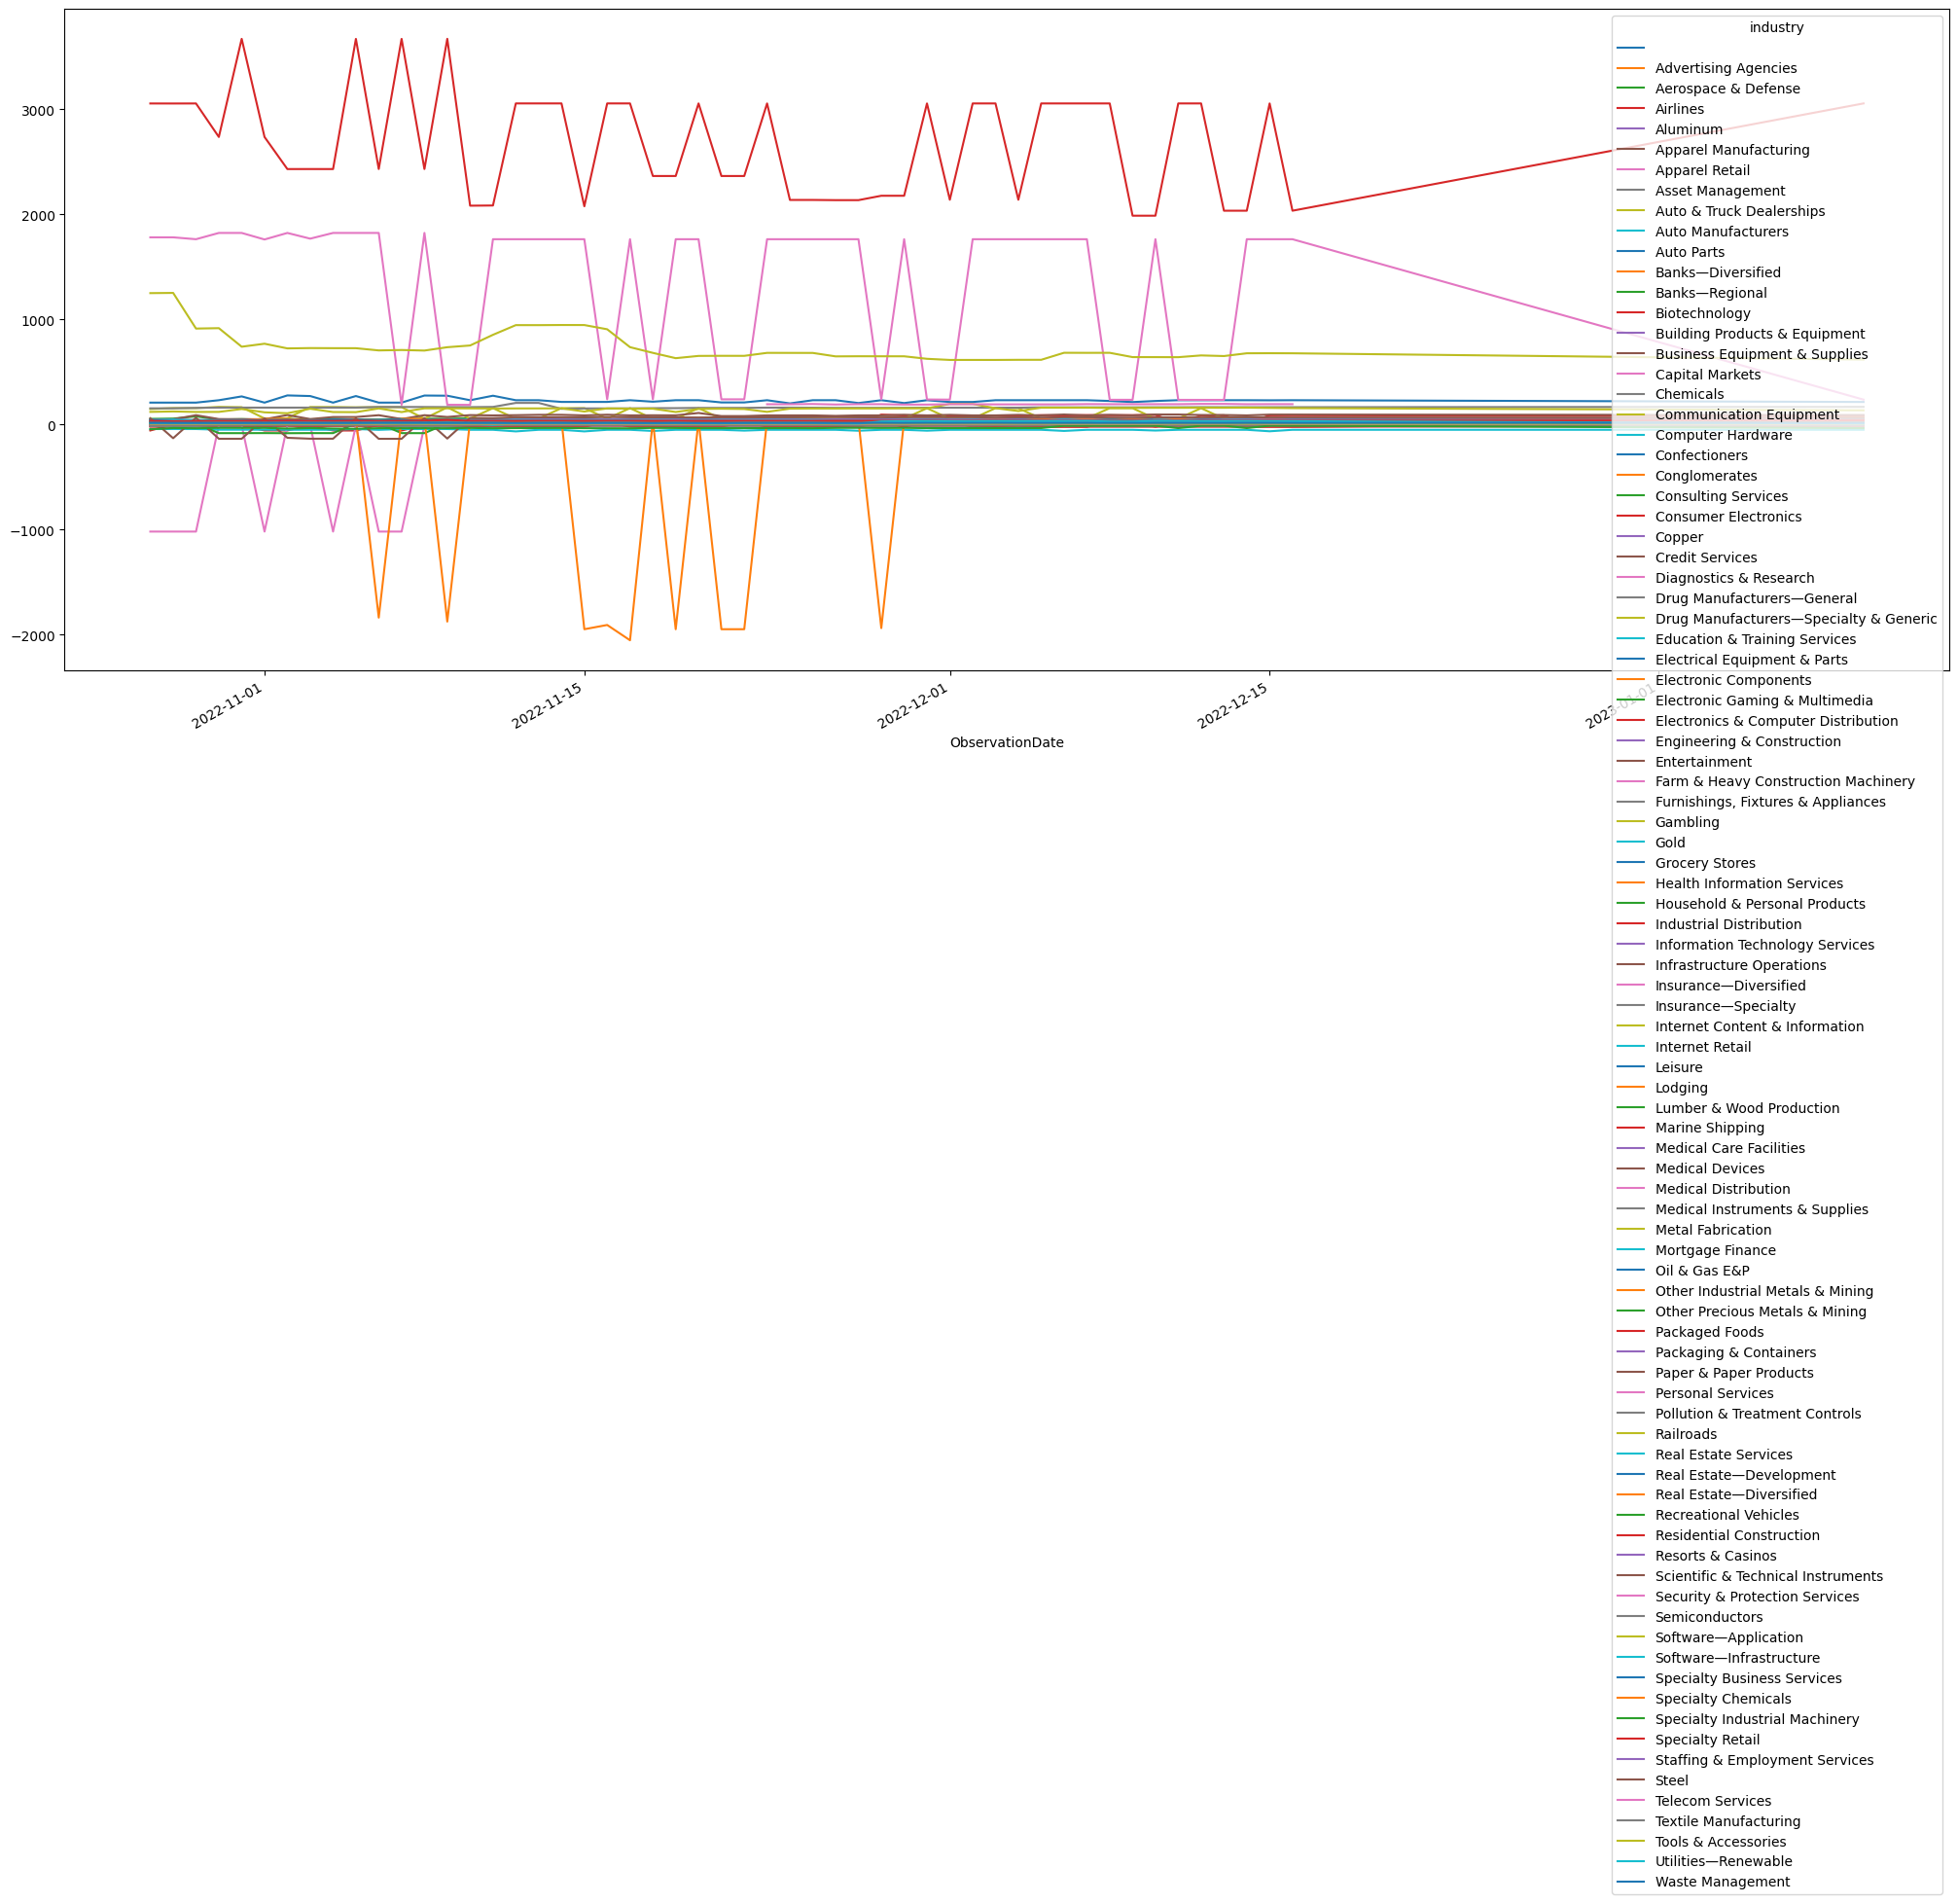

In [133]:
fact_valuation.pivot(index = "ObservationDate", columns = "industry", values = "enterpriseToEbitda").plot(kind = "line", figsize = (25, 10))

In [134]:
fact_valuation

,ObservationDate,industry,enterpriseToEbitda
0,2022-10-27,,208.691000
1,2022-10-27,Advertising Agencies,6.009000
2,2022-10-27,Aerospace & Defense,53.812667
3,2022-10-27,Airlines,-13.390000
4,2022-10-27,Aluminum,6.288000
...,...,...,...
4700,2023-01-10,Telecom Services,2.689000
4701,2023-01-10,Textile Manufacturing,9.229000
4702,2023-01-10,Tools & Accessories,8.429500
4703,2023-01-10,Utilities—Renewable,10.565333
